In [1]:
# ===============================================
# 1️⃣ Imports and setup
# ===============================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# For reproducibility
torch.manual_seed(0)
np.random.seed(0)


In [2]:
# ===============================================
# 2️⃣ Generate synthetic "battery" data
# ===============================================
# Let's make fake current and voltage traces that evolve smoothly over cycles.
# - current(t): fixed sinusoidal shape + noise
# - voltage(t): similar shape but with a gradual "drift" over cycles

num_cycles = 500
seq_len = 200  # samples per cycle

t = np.linspace(0, 2*np.pi, seq_len)

currents = []
voltages = []
cycle_nums = []

for c in range(num_cycles):
    phase_shift = 0.1 * np.sin(c / 50)      # small periodic drift
    ir_drop = 0.02 * c                      # gradual voltage drop with cycle
    amp = 1.0 + 0.05 * np.sin(c / 20)       # amplitude drift

    I = amp * np.sin(t) + 0.02 * np.random.randn(seq_len)
    V = 3.6 + 0.1 * np.sin(t + phase_shift) - ir_drop/1000 + 0.01 * np.random.randn(seq_len)

    currents.append(I)
    voltages.append(V)
    cycle_nums.append(np.ones_like(I) * c)

currents = np.stack(currents)  # (N, L)
voltages = np.stack(voltages)
cycle_nums = np.stack(cycle_nums)


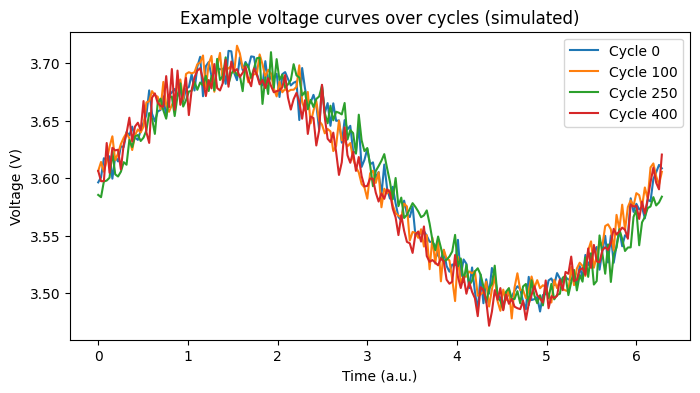

In [3]:
plt.figure(figsize=(8,4))
for c in [0, 100, 250, 400]:
    plt.plot(t, voltages[c], label=f"Cycle {c}")
plt.legend()
plt.title("Example voltage curves over cycles (simulated)")
plt.xlabel("Time (a.u.)")
plt.ylabel("Voltage (V)")
plt.show()


In [4]:
# ===============================================
# 3️⃣ Prepare tensors for PyTorch
# ===============================================
X_current = torch.tensor(currents, dtype=torch.float32).unsqueeze(2)      # (N, L, 1)
X_cycle = torch.tensor(cycle_nums, dtype=torch.float32).unsqueeze(2)      # (N, L, 1)
Y_voltage = torch.tensor(voltages, dtype=torch.float32).unsqueeze(2)      # (N, L, 1)

# Normalize cycle numbers to [0,1]
X_cycle = X_cycle / X_cycle.max()


In [5]:
# ===============================================
# 4️⃣ Define simple 1D CNN model
# ===============================================
class CurrentToVoltageNet(nn.Module):
    def __init__(self, in_channels=2, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, hidden, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden, 1, 1)
        )

    def forward(self, x):
        # x: (B, C, L)
        return self.net(x)

model = CurrentToVoltageNet()
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [6]:
# ===============================================
# 5️⃣ Split into train/test (and simulate "missing" cycles)
# ===============================================
missing_start, missing_end = 300, 350
mask = np.ones(num_cycles, dtype=bool)
mask[missing_start:missing_end] = False

train_idx = np.where(mask)[0]
test_idx = np.arange(missing_start, missing_end)

def make_batch(indices):
    xI = X_current[indices]   # (B, L, 1)
    xC = X_cycle[indices]
    yV = Y_voltage[indices]
    # concat current + cycle as channels
    x = torch.cat([xI, xC], dim=2).permute(0, 2, 1)  # (B, C, L)
    y = yV.permute(0, 2, 1)
    return x, y


In [ ]:
# ===============================================
# 6️⃣ Training loop
# ===============================================
epochs = 400
for epoch in range(epochs):
    model.train()
    xb, yb = make_batch(train_idx)
    pred = model(xb)
    loss = loss_fn(pred, yb)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.6f}")


In [ ]:
# ===============================================
# 7️⃣ Interpolate missing cycles and visualize
# ===============================================
model.eval()

# Predict missing cycles
x_missing, y_missing_true = make_batch(test_idx)
with torch.no_grad():
    y_missing_pred = model(x_missing)

# Convert back to numpy for plotting
y_missing_pred = y_missing_pred.squeeze(1).numpy()
y_missing_true = y_missing_true.squeeze(1).numpy()

# Compare true vs predicted for a few missing cycles
plt.figure(figsize=(10,5))
for i, c in enumerate([300, 320, 340]):
    plt.subplot(1,3,i+1)
    plt.plot(t, y_missing_true[i], label="True", lw=2)
    plt.plot(t, y_missing_pred[i], '--', label="Pred", lw=2)
    plt.title(f"Cycle {c}")
    if i==0: plt.ylabel("Voltage (V)")
    plt.xlabel("Time")
    plt.legend()
plt.tight_layout()
plt.show()
